In [1]:
from zipfile import ZipFile
import os
import pandas as pd
import numpy as np
import pickle
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import gc

In [ ]:
# extracting files from ahsrae-energy-prediction.zip file
with ZipFile('/content/drive/MyDrive/ashrae-energy-prediction.zip', 'r') as zipObj:
  zipObj.extractall('energy_prediction')

# Loading and Exploring of the files before merging

In [ ]:
#loading building_meta into a datafarme
building_metadata=pd.read_csv('/content/energy_prediction/building_metadata.csv')
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [ ]:
#loading train.csv into a datafarme
train=pd.read_csv('/content/energy_prediction/train.csv',parse_dates=['timestamp'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int64         
 1   meter          int64         
 2   timestamp      datetime64[ns]
 3   meter_reading  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 616.9 MB


In [ ]:
# loading weather_train file
weather_train=pd.read_csv('/content/energy_prediction/weather_train.csv',parse_dates=['timestamp'])
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int64         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float64       
 3   cloud_coverage      70600 non-null   float64       
 4   dew_temperature     139660 non-null  float64       
 5   precip_depth_1_hr   89484 non-null   float64       
 6   sea_level_pressure  129155 non-null  float64       
 7   wind_direction      133505 non-null  float64       
 8   wind_speed          139469 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


In [ ]:
#code copied from: https://www.kaggle.com/code/kyakovlev/ashrae-data-minification/notebook
def reduce_mem_usage(df, verbose=True):
    '''This function reduces the size of  dataframe '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# reducing size of data farmes
train=reduce_mem_usage(train)
building_metadata=reduce_mem_usage(building_metadata)
weather_train=reduce_mem_usage(weather_train)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [ ]:
#merging train and building_metadata. we will merge weather_train afetr timesatmp alignment
merge_df=building_metadata.merge(train,on='building_id',how='right')
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   site_id        int8          
 1   building_id    int16         
 2   primary_use    object        
 3   square_feet    int32         
 4   year_built     float16       
 5   floor_count    float16       
 6   meter          int8          
 7   timestamp      datetime64[ns]
 8   meter_reading  float32       
dtypes: datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 771.2+ MB


In [ ]:
# checking percentage of nan values in each column
merge_df.isna().sum()/len(merge_df)*100

site_id           0.000000
building_id       0.000000
primary_use       0.000000
square_feet       0.000000
year_built       59.990033
floor_count      82.652772
meter             0.000000
timestamp         0.000000
meter_reading     0.000000
dtype: float64

Observation: Only year_built and floor_count contains missing values

In [ ]:
#removing columns with high percent of nan values from mergr_df
del merge_df['floor_count']
del merge_df['year_built']
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   site_id        int8          
 1   building_id    int16         
 2   primary_use    object        
 3   square_feet    int32         
 4   meter          int8          
 5   timestamp      datetime64[ns]
 6   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 694.1+ MB


In [ ]:
#saving merge_df to drive
with open("/content/drive/MyDrive/merge_df.pkl",'wb') as f:
  pickle.dump(merge_df,f)

In [ ]:
#checking percentage of nan values of each column in weather_train
weather_train.isna().sum()/len(weather_train)*100

site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
cloud_coverage        49.489529
dew_temperature        0.080845
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
dtype: float64

Observation: in weather train only cloud_coverage, precip_depth_1_hr, sea_level_presuure, wind_direction and wind speed contain missing values. But we see that sea_level_presuure, wind_direction and wind speed has very low percentage of missing values.

In [ ]:
#removing columns which conain high number of nan values from weather tarin
del weather_train['cloud_coverage']
del weather_train['precip_depth_1_hr']
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int8          
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float16       
 3   dew_temperature     139660 non-null  float16       
 4   sea_level_pressure  129155 non-null  float16       
 5   wind_direction      133505 non-null  float16       
 6   wind_speed          139469 non-null  float16       
dtypes: datetime64[ns](1), float16(5), int8(1)
memory usage: 2.5 MB


# **Weather_train time stamp alignment**

Checking for timestamp descrepency:


In [ ]:
# code copied from: https://www.kaggle.com/code/abhigyandatta/eda-ashrae-energy-consumption

temp_df=weather_train[['site_id','timestamp','air_temperature']]

 # calculate ranks of hourly temperatures within date/site_id chunks
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date])['air_temperature'].rank('average')

# create 2D dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)
df_2d.head()

timestamp,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
site_id,,,,,,,,,,,,,,,,,,,,,
0,15.219945,13.342896,11.927596,10.618852,9.524590,8.079235,6.971311,5.808743,4.898630,4.352055,...,13.911202,16.273224,18.124317,19.501366,20.579235,21.325137,21.110656,20.045082,18.155738,15.747268
1,8.817308,7.635989,6.647945,5.532787,4.775956,4.650273,5.389344,7.281421,9.328767,12.012295,...,21.620548,21.446281,20.300824,18.640110,16.797260,14.842466,12.997260,11.407104,9.693989,7.989041
2,21.678962,20.209016,18.331507,16.274590,14.565574,12.948087,11.372951,10.054645,8.568306,7.090164,...,2.815574,5.136612,8.860656,12.079235,14.592896,16.721311,18.747268,20.476712,21.598361,21.982240
3,16.442466,14.713699,12.968579,11.761644,10.605191,9.387671,8.298630,6.942466,6.131148,5.039617,...,11.437158,13.897541,15.998634,17.997268,19.662568,20.545082,20.678082,20.015068,18.034153,15.975410
4,20.916438,19.107923,16.710383,14.281421,12.266393,10.857923,9.569672,8.433060,7.674863,6.842896,...,4.815574,6.509563,9.747268,13.000000,15.859290,17.969945,19.752732,21.128415,21.687158,21.489071


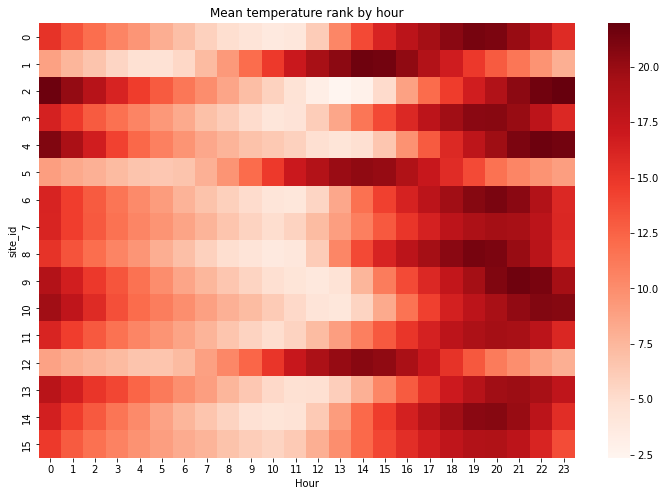

In [ ]:
#plotting heatmap of mean tempearture rank by hour
plt.figure(figsize=(12,8))
sns.heatmap(df_2d,cmap='Reds')
plt.xlabel('Hour')
plt.title('Mean temperature rank by hour')
plt.show()

Temperature should be high during noon time i.e 11 hrs to 15 hrs. From above heatmap we can see that only sites 1,5 and 12 are following this. Thats means remaining sites are not aligned with the local time zone. 

In [ ]:
# code copied from: https://www.kaggle.com/code/abhigyandatta/eda-ashrae-energy-consumption
def time_alignment(df):
  ''' This function aligns the timestamp '''

  temp_df=df[['site_id','timestamp','air_temperature']]

  # calculate ranks of hourly temperatures within date/site_id chunks
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')

  # create 2D dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
  df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

  # align scale, so each value within row is in [0,1] range
  df_2d = df_2d / df_2d.max(axis=1).values.reshape((-1,1))

  # assuming site ids (1,5,12) has the most correct temp peaks at 14:00
  site_ids_offsets= pd.Series(df_2d.values.argmax(axis=1) - 14)

  temp_df['offset'] = temp_df.site_id.map(site_ids_offsets)

  # add offset
  temp_df['timestamp_aligned'] = (temp_df.timestamp - pd.to_timedelta(temp_df.offset, unit='H'))
  
  # replace the timestamp with aligned timestamps in the original dataframe
  df['timestamp']=temp_df['timestamp_aligned']

  return df 


In [ ]:
weather_train=time_alignment(weather_train)

In [ ]:
#saving weather_train to drive
with open("/content/drive/MyDrive/weather_train.pkl",'wb') as f:
  pickle.dump(weather_train,f)

In [ ]:
with open("/content/drive/MyDrive/weather_train.pkl",'rb') as f:
  weather_train=pickle.load(f)

In [ ]:
#Checking for timestamp descrepencies after time alignment
temp_df=weather_train[['site_id','timestamp','air_temperature']]
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

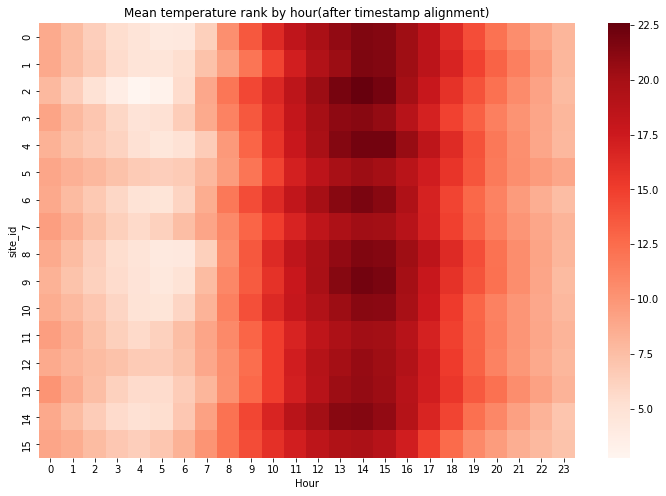

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_2d,cmap='Reds')
plt.xlabel('Hour')
plt.title('Mean temperature rank by hour(after timestamp alignment)')
plt.show()

In above heatmap we can see that for all site ids temperature is high during noon time. That means our timestamps have been aligned.

# **EDA**

In [ ]:
#EDA of merge_df(buiding_metadata + train)
x=len(merge_df['building_id'].unique())
y=len(merge_df['primary_use'].unique())
z=len(merge_df['site_id'].unique())
time_min=merge_df['timestamp'].min() ; time_max=merge_df['timestamp'].max()
print("data set contains data of {} buildings: ".format(x))
print("There are {} types of primary_use".format(y))
print("The data is taken from {} different sites around the world: ".format(z))
print("train data of the buildings is from {} to {}".format(time_min,time_max))

data set contains data of 1449 buildings: 
There are 16 types of primary_use
The data is taken from 16 different sites around the world: 
train data of the buildings is from 2016-01-01 00:00:00 to 2016-12-31 23:00:00


In [ ]:
#EDA of weather_train
x=len(weather_train.site_id.unique())
print("Total number of diferent sites in weather_train is: ",x)
time_min=weather_train['timestamp'].min() ; time_max=weather_train['timestamp'].max()
print("weather_train contains data from {} to {}".format(time_min,time_max))

Total number of diferent sites in weather_train is:  16
weather_train contains data from 2015-12-31 15:00:00 to 2016-12-31 23:00:00


In [ ]:
#merging building_metadata,train and weather_train 
merge_df=merge_df.merge(weather_train,on=['site_id','timestamp'],how='left')


In [ ]:
#finding number of duplicate rows
merge_df.duplicated().sum()

0

observation:There are no duplicates in our train data

In [ ]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             int8          
 1   building_id         int16         
 2   primary_use         object        
 3   square_feet         int32         
 4   meter               int8          
 5   timestamp           datetime64[ns]
 6   meter_reading       float32       
 7   air_temperature     float16       
 8   dew_temperature     float16       
 9   sea_level_pressure  float16       
 10  wind_direction      float16       
 11  wind_speed          float16       
dtypes: datetime64[ns](1), float16(5), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 886.9+ MB


Our train data contains more than 20 million (20216100) data points

In [ ]:
print("number of unique buildings in our train data is:",merge_df.building_id.nunique())
time_min=merge_df['timestamp'].min() ; time_max=merge_df['timestamp'].max()
print("our train data (merge_df) contains data from {} to {}".format(time_min,time_max))

number of unique buildings in our train data is: 1449
our train data (merge_df) contains data from 2016-01-01 00:00:00 to 2016-12-31 23:00:00


In [ ]:
# Meter readings of site 0 are given in KBTU unit we will convert it to KWh
merge_df.loc[merge_df['site_id'] == 0,['meter_reading']]*=0.2931

In [ ]:
#checking for columns with nan values
merge_df.isna().sum()*100/len(merge_df)

site_id               0.000000
building_id           0.000000
primary_use           0.000000
square_feet           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
air_temperature       0.542231
dew_temperature       0.559455
sea_level_pressure    6.146022
wind_direction        7.229614
wind_speed            0.774551
dtype: float64

observation: air_temperature, dew_temperature, sea_level_pressure, wind_direction and wind_speed contains few percent of nan values we will impute them.


In [ ]:
# imputing nan values
#code referred from: https://www.kaggle.com/code/abhigyandatta/eda-ashrae-energy-consumption
imputer=SimpleImputer(strategy='median')
merge_df[['air_temperature','dew_temperature','sea_level_pressure','wind_direction','wind_speed']]=imputer.fit_transform(merge_df[['air_temperature','dew_temperature','sea_level_pressure','wind_direction','wind_speed']])
merge_df.isna().sum()*100/len(merge_df)

site_id               0.0
building_id           0.0
primary_use           0.0
square_feet           0.0
meter                 0.0
timestamp             0.0
meter_reading         0.0
air_temperature       0.0
dew_temperature       0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
dtype: float64

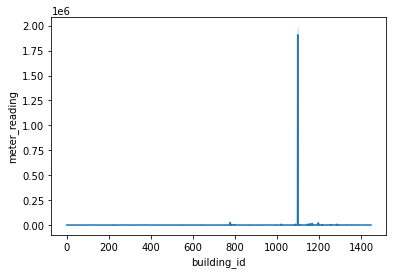

In [ ]:
# building id vs meter reading
sns.lineplot(x='building_id',y='meter_reading',data=merge_df)
plt.show()

In [ ]:
x=merge_df['meter_reading'].max()
merge_df[merge_df['meter_reading']==x]


,site_id,building_id,primary_use,square_feet,meter,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
8907488,13,1099,Education,332884,2,2016-06-13 09:00:00,21904700.0,24.40625,17.203125,1013.0,210.0,2.099609


We can see that meter readings of building id 1099 at site id 13 is having outliers.

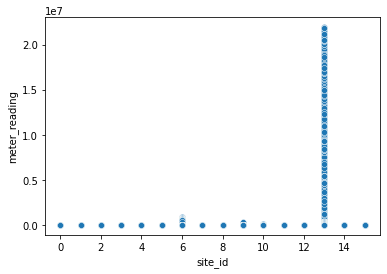

In [ ]:
# site id vs meter reading
sns.scatterplot(x='site_id',y='meter_reading',data=merge_df)
plt.show()

We can see that meter readings of site id 13 is having many outliers. This may be because building id 1099 is located in site id 13.

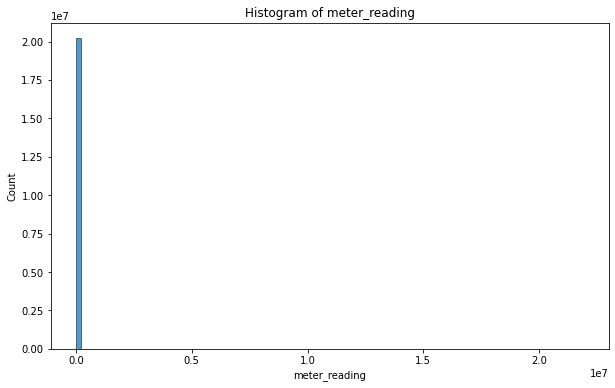

In [11]:
#histogram of meter readings
plt.figure(figsize=(10,6))
sns.histplot(merge_df['meter_reading'],bins=100)
plt.title('Histogram of meter_reading')
plt.show()


Histogram of meter readings is higly skewed towards left. Many of meter readings are zero.

In [ ]:
# getting percentage of electricity meter readings 0 out of total electricity meters
merge_df[(merge_df['meter_reading']==0) & (merge_df['meter']==0)]['meter_reading'].count()/merge_df[merge_df['meter']==0]['meter_reading'].count()*100

4.395762840449021

Out of total electricity meter readings, 4.3958% meter readings are zero. In a building is very rare that the electricity consumption is zero at any moment. A building always has electricity consumption. As it has a lot of permanently connected devices. Hence electricity meters with zero reading are outliers.
Source: https://www.kaggle.com/code/juanmah/ashrae-zeros/notebook

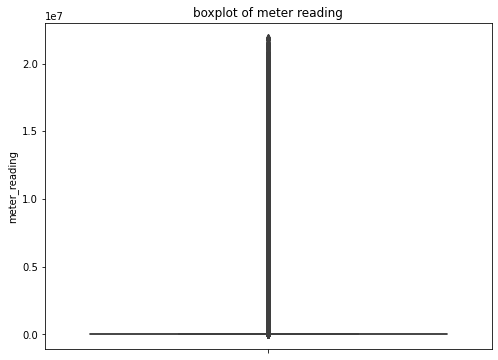

In [ ]:
# boxplot of meter reading
plt.figure(figsize=(8,6))
sns.boxplot(y=merge_df['meter_reading'])
plt.title("boxplot of meter reading")
plt.show()

From above boxplot we can see that meter readings contain large outliers.

In [ ]:
per_75=merge_df.meter_reading.quantile(q=0.75)
per_99=merge_df.meter_reading.quantile(q=0.99)
print("75 percentage of meter readings in our tarin data are below "+str(per_75) + " kWh")
print("99 percentage of meter readings in our tarin data are below "+str(per_99) + " kWh")

75 percentage of meter readings in our tarin data are below 250.3000030517578 kWh
99 percentage of meter readings in our tarin data are below 5178.240234375 kWh


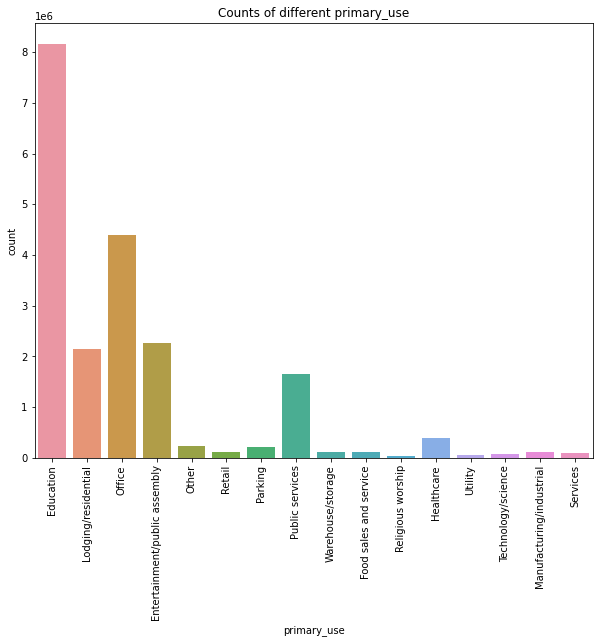

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(x='primary_use',data=merge_df)
plt.title('Counts of different primary_use')
plt.xticks(rotation=90)
plt.show()

Educational buildings have largest frequency and Religious worship has least count in our data.

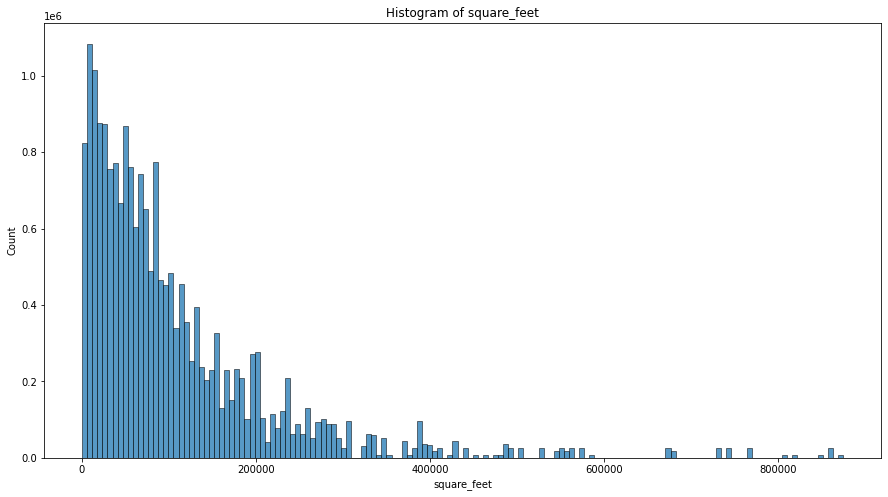

In [ ]:
# Histogram of square_feet
plt.figure(figsize=(15,8))
sns.histplot(merge_df['square_feet'],bins=150)
plt.title('Histogram of square_feet')
plt.show()

Histogram of area of buildings is highly skewed towards left. Also there are some buildings with unusual large area.

Text(0.5, 1.0, 'boxplot of area of buildings in square feet')

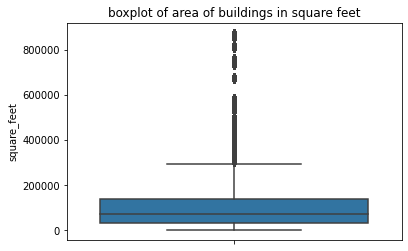

In [ ]:
sns.boxplot(y=merge_df['square_feet'])
plt.title("boxplot of area of buildings in square feet")

From above box plot it seems that there are some outliers in the area of buildings but not sure about it. Approximately 75% of buildings have area less than 1.5 lakh square feet.

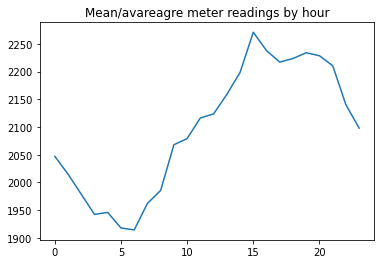

In [ ]:
# avareagre meter readings by hour
hour_mean=merge_df.groupby([merge_df.timestamp.dt.hour]).meter_reading.mean().reset_index()
sns.lineplot(x=list(hour_mean.timestamp),y=list(hour_mean.meter_reading))
plt.title("Mean/avareagre meter readings by hour")
plt.show()

Meter readings drop from midnight upto 6 am. That means meter readings are low from midnight upto 6 am. After 6 am again start increasing and at 3 pm meter readings are maximum. 
Energy is consumed more during  2 pm to 8 pm.



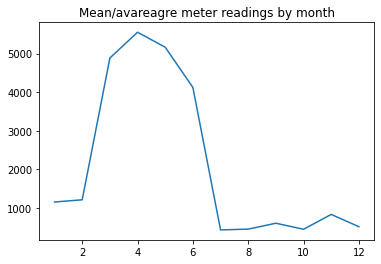

In [ ]:
# Mean/average meter readings by month
month_mean=merge_df.groupby([merge_df.timestamp.dt.month]).meter_reading.mean().reset_index()
sns.lineplot(x=list(month_mean.timestamp),y=list(month_mean.meter_reading))
plt.title("Mean/avareagre meter readings by month")
plt.show()

Less energy is consumed in january and february and from july to december. Most of the energy is consumed from march to june. The meter reading is at its peak in april. 

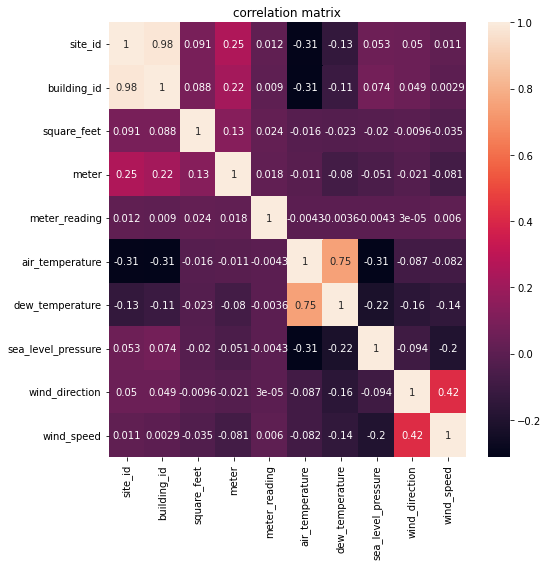

In [ ]:
# correlation between features
corr_matrix=merge_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix,annot = True)
plt.title("correlation matrix")
plt.show()

site_id and building_id have strong correlation between them. Air_temperature and dew_temperature also have good correlation between them. 

In [ ]:
# correlation of features with target value(meter_reading)
x=merge_df.corr()['meter_reading'].sort_values(ascending=False)
pd.DataFrame(x)

,meter_reading
meter_reading,1.000000
square_feet,0.024303
meter,0.017673
site_id,0.012108
building_id,0.008997
wind_speed,0.005986
wind_direction,0.000030
dew_temperature,-0.003626
sea_level_pressure,-0.004282
air_temperature,-0.004293


None of the features have a good correlation with the target value- meter_reading. As compared to other features square_feet is most correlatedwith traget values.

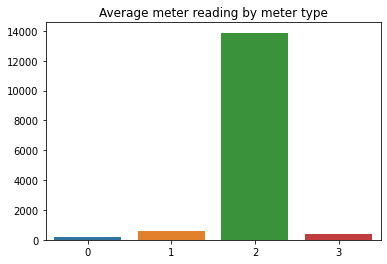

In [ ]:
# Average meter reading by meter type
meter_groups=merge_df.groupby(['meter']).meter_reading.mean().reset_index()
sns.barplot(x=list(meter_groups.meter),y=list(meter_groups.meter_reading))
plt.title("Average meter reading by meter type")
plt.show()

Energy consumption of steam is more than other meters. Electricity consumes least energy.

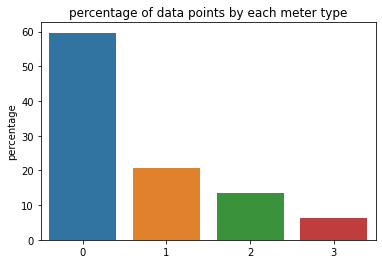

In [ ]:
# percentage of data points by each meter type
x=(merge_df.groupby(['meter'])['meter_reading'].count()/len(merge_df)*100).reset_index()
sns.barplot(x=list(x.meter),y=list(x.meter_reading))
plt.title("percentage of data points by each meter type")
plt.ylabel("percentage")
plt.show()

Meter 0 i.e Electricity meter has most of the data points in our data. 60% of our data contains meter type 0. 
Meter type 3 i.e hot water is the least equiped meter in our data.


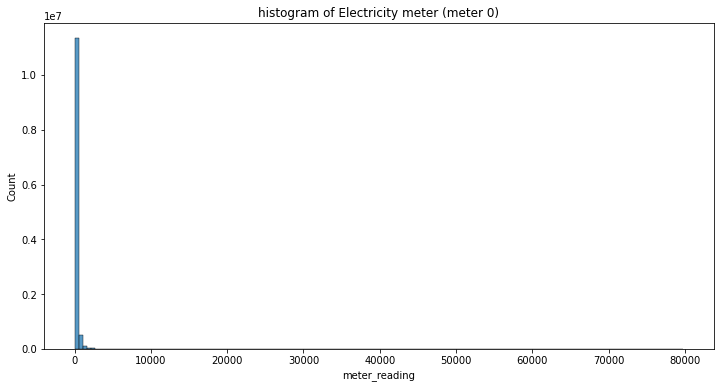

In [ ]:
# histogram of Electricity meter (meter 0)
plt.figure(figsize=(12,6))
sns.histplot(merge_df[merge_df['meter']==0]['meter_reading'],bins=150)
plt.title("histogram of Electricity meter (meter 0)")
plt.show()

we can see that histogram is higly skewed towards left. Also there are few electricity meters with unusual large readings.

Text(0.5, 1.0, 'boxplot of meter readings for electricity(meter 0)')

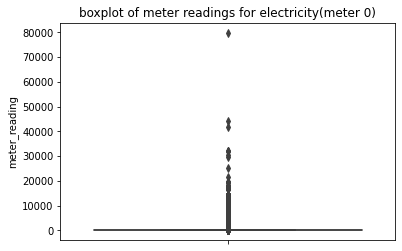

In [ ]:
# boxplot of meter readings for electricity(meter 0)
sns.boxplot(y=merge_df[merge_df['meter']==0]['meter_reading'])
plt.title("boxplot of meter readings for electricity(meter 0)")

In [ ]:
x=merge_df[merge_df['meter']==0]['meter_reading'].max()
merge_df[merge_df['meter_reading']==x]


,site_id,building_id,primary_use,square_feet,meter,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
15975226,9,993,Education,428647,0,2016-10-17 07:00:00,79769.0,25.0,22.203125,1012.0,180.0,2.599609


We can see that meter 0 reading of building 993 is unusually high (79769). It is an outlier.

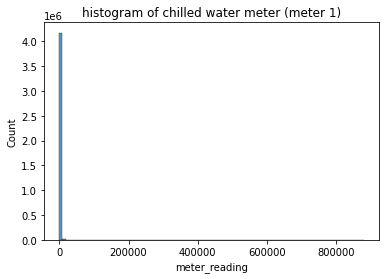

In [ ]:
# histogram of chilled water meter (meter 1)
sns.histplot(merge_df[merge_df['meter']==1]['meter_reading'],bins=100)
plt.title("histogram of chilled water meter (meter 1)")
plt.show()

The histogram of meter 1 readings is highly skewed towards left.

Text(0.5, 1.0, 'boxplot of meter readings for chilled water(meter 1)')

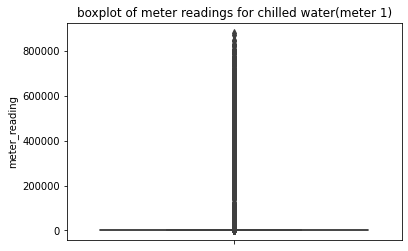

In [ ]:
# boxplot of meter readings for chilled water(meter 1)
sns.boxplot(y=merge_df[merge_df['meter']==1]['meter_reading'])
plt.title("boxplot of meter readings for chilled water(meter 1)")

In [ ]:
x=merge_df[merge_df['meter']==1]['meter_reading'].max()
merge_df[merge_df['meter_reading']==x]

,site_id,building_id,primary_use,square_feet,meter,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
13851463,6,778,Entertainment/public assembly,108339,1,2016-09-09 17:00:00,880374.0,32.1875,18.90625,1013.0,200.0,2.599609


Meter 1 has highest reading of 880374 at building id 778 which is an outlier.

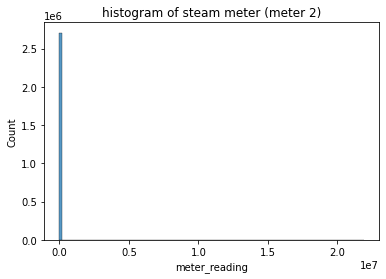

In [ ]:
# histogram of steam meter (meter 2)

sns.histplot(merge_df[merge_df['meter']==2]['meter_reading'],bins=100)
plt.title("histogram of steam meter (meter 2)")
plt.show()

Text(0.5, 1.0, 'boxplot of meter readings for steam(meter 2)')

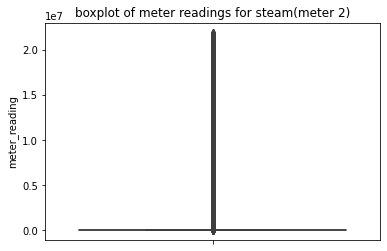

In [ ]:

sns.boxplot(y=merge_df[merge_df['meter']==2]['meter_reading'])
plt.title("boxplot of meter readings for steam(meter 2)")

In [ ]:
x=merge_df[merge_df['meter']==2]['meter_reading'].max()
merge_df[merge_df['meter_reading']==x]

,site_id,building_id,primary_use,square_feet,meter,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
8907488,13,1099,Education,332884,2,2016-06-13 09:00:00,21904700.0,24.40625,17.203125,1013.0,210.0,2.099609


Histogram of meter 2 readings is highly skewed towards left.
The highes value of meter 2 readings is 21904700 at building id 1099 which is an outlier.

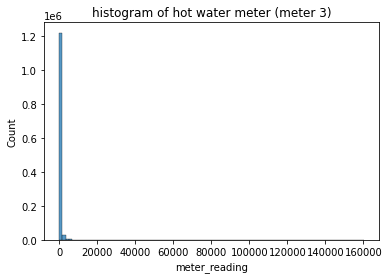

In [3]:
# histogram of hot water meter (meter 3)
sns.histplot(merge_df[merge_df['meter']==3]['meter_reading'],bins=100)
plt.title("histogram of hot water meter (meter 3)")
plt.show()

hot water meter histogram is highly skewed towards left.

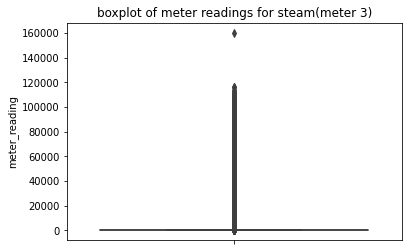

In [ ]:
sns.boxplot(y=merge_df[merge_df['meter']==3]['meter_reading'])
plt.title("boxplot of meter readings for steam(meter 3)")
plt.show()

In [ ]:
x=merge_df[merge_df['meter']==3]['meter_reading'].max()
merge_df[merge_df['meter_reading']==x]

,site_id,building_id,primary_use,square_feet,meter,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
19730988,10,1021,Entertainment/public assembly,213762,3,2016-12-23 10:00:00,160187.0,0.600098,-5.601562,1016.0,160.0,1.5


The highest reading of hot water meter is 160187 at building id 1021. This is an otlier as compared to other hot water meter readings

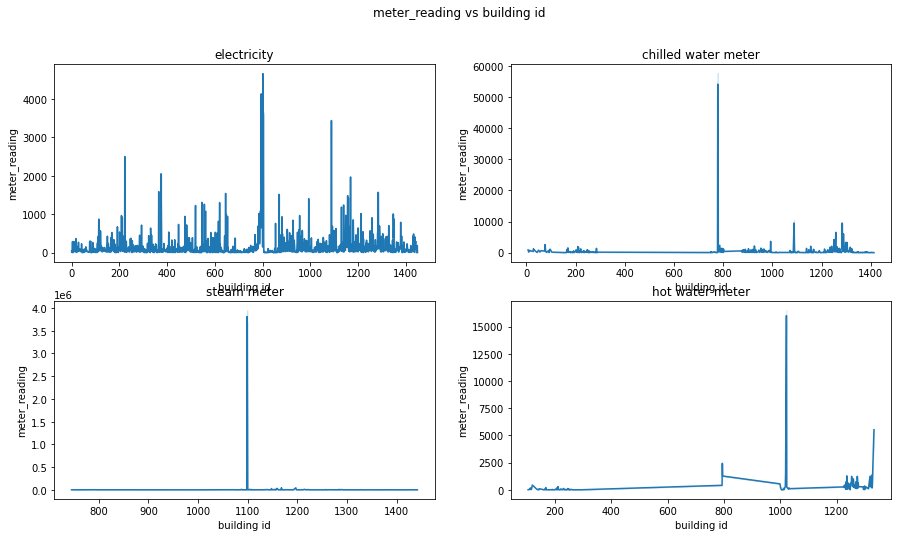

In [ ]:
# Average meter readings by hour for each meter type
fig,ax=plt.subplots(2,2,figsize=(15,8))
fig.suptitle("meter_reading vs building id")



# electricity meter
x1=merge_df[merge_df['meter']==0][['meter','meter_reading','building_id']]
sns.lineplot(ax=ax[0,0],x=list(x1.building_id),y=list(x1.meter_reading))
ax[0,0].set(title="electricity",xlabel='building id',ylabel='meter_reading')
ax
gc.collect()

# chilled water meter
x1=merge_df[merge_df['meter']==1][['meter','meter_reading','building_id']]
sns.lineplot(ax=ax[0,1],x=list(x1.building_id),y=list(x1.meter_reading))
ax[0,1].set(title="chilled water meter",xlabel='building id',ylabel='meter_reading')
gc.collect()

#steam meter
x1=merge_df[merge_df['meter']==2][['meter','meter_reading','building_id']]
sns.lineplot(ax=ax[1,0],x=list(x1.building_id),y=list(x1.meter_reading))
ax[1,0].set(title="steam meter",xlabel='building id',ylabel='meter_reading')
gc.collect()

# hot water meter
x1=merge_df[merge_df['meter']==3][['meter','meter_reading','building_id']]
sns.lineplot(ax=ax[1,1],x=list(x1.building_id),y=list(x1.meter_reading))
ax[1,1].set(title="hot water meter",xlabel='building id',ylabel='meter_reading')

plt.show()

we can see unusual spikes in the plots of electricity,chilled water, steam and hot water. These spikes are the outliers.

# Conclusions from EDA
* timestamp of weather_train was not aligned which we have aligned.
* Our Train data set contains 1449 diferent buildings from 16 different sites.
* Train Data set contains data from 1 jan 2016 to 31 dec 2016.
* I have removed the features year_built, floor_count, cloud_coverage, precip_depth_1_hr, sea_level_presuure, wind_direction and wind speed.These features contained high number of nan values(greater than 25%).
* There were no duplicates value in the data.
* Train data set contains 20216100 data points.
* I have also converted the meter readings of site id 0 to kWh.
* The features which contained less number of nan values were imputed using median method.
* Building 1099 is having an outlier for meter type 2. Its meter reading is 21904700 which is an anomaly. Building 1099 is situated at site id 13.
* Out of total electricity meter readings, 4.3958% meter readings are zero. In a building is very rare that the electricity consumption is zero at any moment. A building always has electricity consumption. As it has a lot of permanently connected devices. Hence electricity meters with zero reading are outliers.
* 75 percentage of meter readings in our train data are below 250.300 kWh. 99 percentage of meter readings in our train data are below 5178.2402 kWh.
* Approximately 75% of buildings have area less than 1.5 lakh square feet. From boxplot it seems that there may be some outlires. Very few buildings have area above 8 lakh square feet
* Meter readings drop from midnight upto 6 am. That means meter readings are low from midnight upto 6 am. After 6 am again start increasing and at 3 pm meter readings are maximum. Energy is consumed more during 2 pm to 8 pm
* Less energy is consumed in january and february and from july to december. Most of the energy is consumed from march to june. The meter reading is at its peak in april.
* site_id and building_id have strong correlation between them. Air_temperature and dew_temperature also have good correlation between them.
* None of the features have a good correlation with the target value- meter_reading.
* Energy consumption of steam is more than other meters. Electricity consumes least energy.
* Meter 0 i.e Electricity meter has most of the data points in our data. 60% of our data contains meter type 0. Meter type 3 i.e hot water is the least equiped meter in our data.
* The histograms of each meter type for meter readings are highly skewed towards left.
* The highest reading for meter 0 is 79769 kWh at building 993 which seems like an outlier as compared to othere electricity meter readings.
* The highest reading for meter 1 is 880374 kWh at building id 778 which i think is unusually high(outlier). 
* The highest reading for meter 2 is 21904700 kWh at building 1099 which is an outlier. The highest reading of hot water meter is 160187 at building id 1021 which seems like an outlier as compared to otherhot water meter readings.